<a href="https://colab.research.google.com/github/Arazsh/Sarcasm-in-News-Headlines/blob/main/Sarcasm_News_Headlines_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import json
import tensorflow as tf
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, ReLU, GRU

In [8]:
#Downloading the News Headlines Dataset For Sarcasm Detection, using the direct link provided by Laurence Moroney.
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json
  


with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

#Extracting the news headlines as sentences and the labels. 1 if the record is sarcastic otherwise 0
sentences = [] 
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

data_size = len(sentences)
print(data_size)


--2020-10-22 01:01:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 172.253.63.128, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2020-10-22 01:01:07 (229 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]

26709


In [9]:
#Tokenizing the 26709 sentences in the dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
#The number of unique words in the data
vocab_size = len(word_index)
print(vocab_size)
#print(word_index)
#40 is the max length of sentences. The smaller sentences are zero padded.
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post')
#Displaying an example padded sequence
print(padded[2])
print(padded.shape)

#Dividing the data into train and validation
test_portion = 0.2
split = int(test_portion * data_size)

test_sequences = padded[0:split]
training_sequences = padded[split:]
test_labels = labels[0:split]
training_labels = labels[split:]

print(len(test_sequences), len(training_sequences), len(test_labels), len(training_labels))

29656
[  144   837     1   906  1748  2092   581  4718   220   142    38    45
     1 10735     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(26709, 40)
5341 21368 5341 21368


In [10]:
#Downloading the 100 dimension version Global Vectors for Word Representation. The direct link is provided by Laurence Moroney.
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(embeddings_index))
embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-10-22 01:01:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.15.80, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   193MB/s    in 1.7s    

2020-10-22 01:01:22 (193 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

400000


In [11]:
#Building and compiling the model
model = tf.keras.Sequential([
    Embedding(vocab_size+1, 100, input_length=40, weights=[embeddings_matrix], trainable=False),
    Conv1D(512, 5, strides=1, padding="causal"),
    BatchNormalization(),
    ReLU(),
    Conv1D(512, 5, strides=1, padding="causal"),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(pool_size=2),
    Conv1D(256, 5, strides=1, padding="causal"),
    BatchNormalization(),
    ReLU(),
    Conv1D(256, 5, strides=1, padding="causal"),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(pool_size=2),
    GRU(256, return_sequences = True),
    Dropout(0.1),
    GRU(128),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation= 'relu'),
    Dropout(0.5),
    Dense(64, activation= 'relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4) ,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           2965700   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 40, 512)           256512    
_________________________________________________________________
batch_normalization_4 (Batch (None, 40, 512)           2048      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 40, 512)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 40, 512)           1311232   
_________________________________________________________________
batch_normalization_5 (Batch (None, 40, 512)           2048      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 40, 512)          

In [14]:
#Converting the data into numpy arrays
test_sequences = np.array(test_sequences)
training_sequences = np.array(training_sequences)
test_labels = np.array(test_labels)
training_labels = np.array(training_labels)

#Fitting the model for 10 epochs
history = model.fit(training_sequences, training_labels, epochs=10, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Epoch 1/10
668/668 - 9s - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.5989 - val_accuracy: 0.8482
Epoch 2/10
668/668 - 9s - loss: 0.0276 - accuracy: 0.9912 - val_loss: 0.9959 - val_accuracy: 0.8178
Epoch 3/10
668/668 - 9s - loss: 0.0300 - accuracy: 0.9904 - val_loss: 0.8137 - val_accuracy: 0.8111
Epoch 4/10
668/668 - 9s - loss: 0.0244 - accuracy: 0.9921 - val_loss: 0.9134 - val_accuracy: 0.8184
Epoch 5/10
668/668 - 9s - loss: 0.0244 - accuracy: 0.9930 - val_loss: 0.7791 - val_accuracy: 0.8307
Epoch 6/10
668/668 - 9s - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.7792 - val_accuracy: 0.8416
Epoch 7/10
668/668 - 9s - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.6063 - val_accuracy: 0.8525
Epoch 8/10
668/668 - 9s - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.7739 - val_accuracy: 0.8564
Epoch 9/10
668/668 - 9s - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.6787 - val_accuracy: 0.8420
Epoch 10/10
668/668 - 9s - loss: 0.0206 - accuracy: 0.9935 - val_loss: 0.6041 - val_accuracy: 0.8575

<Figure size 432x288 with 0 Axes>

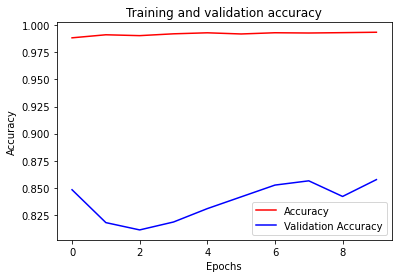

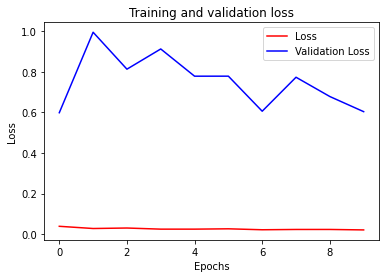

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

#Extracting the loss and accuracy for training and validation

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

#Number of epochs
epochs=range(len(acc)) 

#Plotting training and validation accuracy vs. epochs

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#Plotting training and validation loss vs. epochs

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()